<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/browning_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dive Prediction - Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 11 x 5s
* *Output resolution*: 1 x 55s
* *Representation of trajectories* : Time series
* *Layers* : convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/data_train.csv')
data_validation = pd.read_csv('./data/data_validation.csv')
data_test = pd.read_csv('./data/data_test.csv')

## choose resolution

In [5]:
resolution = 5

data_train_new = change_resolution(data_train, resolution)
data_validation_new = change_resolution(data_validation, resolution)
data_test_new = change_resolution(data_test, resolution)

data_train_new = standardize_data(data_train_new)
data_validation_new = standardize_data(data_validation_new)
data_test_new = standardize_data(data_test_new)

data_train_new.head()

,trip,datetime,lon,lat,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T1,2008-12-05 15:12:49,-77.262463,-11.773780,0,10.905508,-14.088332,1.453765,1.534847,0.598536,0.969922,-0.243417
3,P1108_46_SV_T1,2008-12-05 15:12:54,-77.262588,-11.774210,0,9.952950,22.080560,1.451727,1.529290,0.544953,0.926656,0.375910
4,P1108_46_SV_T1,2008-12-05 15:12:59,-77.262878,-11.774583,0,10.435542,21.390128,1.446998,1.524470,0.572100,0.931119,0.364716
5,P1108_46_SV_T1,2008-12-05 15:13:04,-77.263210,-11.774875,0,9.726889,10.787224,1.441584,1.520697,0.532237,0.982329,0.187162
6,P1108_46_SV_T1,2008-12-05 15:13:09,-77.263615,-11.775112,0,10.283314,11.067779,1.434981,1.517634,0.563537,0.981401,0.191970


## choose window

In [126]:
# Hyperparameters
window = 11
variable = ('lon_std', 'lat_std')

train_set = TrajDataSet(data_train_new, window, variable)

In [134]:
class Center(object):
    def __call__(self, sample):
        traj, dd, dive = sample
        window = len(dive)
        dive_new = dive[int(window/2)]

        return (traj, dd, np.array([dive_new]))

c = Center()

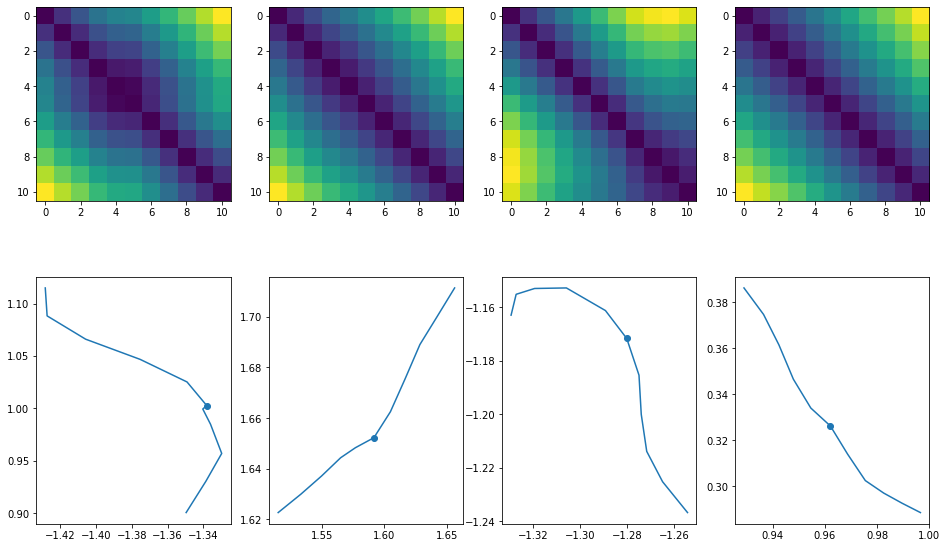

In [136]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, matrix_dist, dive = c(train_set[i])

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    plt.plot(traj[0,:], traj[1,:])
    i = int(window/2)
    if np.array(dive) == 1 :
        plt.scatter(traj[0,i], traj[1,i], c= 'orange')
    else:
      plt.scatter(traj[0,i], traj[1,i])

# Neural Network

In [152]:
# hyperparameters
batch_size = 512

## reduce size dataset
train_set = TrajDataSet(data_train_new, window, variable, transform = transforms.Compose([Center(), ToTensor()]))
validation_set = TrajDataSet(data_validation_new, window, variable, transform = transforms.Compose([Center(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [170]:
class H2O(nn.Module):

    def __init__(self):
        super(H2O, self).__init__()

        self.cnn = nn.Sequential(
            nn.Linear(22,40),
            nn.ReLU(),
            nn.Linear(40,200),
            nn.ReLU(),
            nn.Linear(200,200),
            nn.ReLU(),
            nn.Linear(200,200),
            nn.ReLU(),
            nn.Linear(200,1)
        )

    def forward(self, x):
        out = x.reshape((batch_size, 1, 22))
        out = self.cnn(out)
        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))

In [171]:
# get sample
x, y, z = next(iter(train_loader)) 
weight = torch.FloatTensor([30])

# Forward model
model = H2O()

out = model(x)

# Loss and score
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)
criterion(out, z)
get_score(out, z)

(60.0, 44.0)

In [172]:
## get Loss weight
torch.sum(z==z)/torch.sum(z)

tensor(51.2000)

## Training

In [173]:
# switch to GPU
model = H2O()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
weight = weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [174]:
# Train the model
nb_epoch = 5

global_loss_train = []
global_loss_validation = []
    
for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y, z) in enumerate(train_loader):
        i+=1
        # send to GPU
        x, y, z = x.to(device), y.to(device), z.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, z)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, (x, y, z) in enumerate(train_loader):
            j+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_train.append(loss.item())
            list_score_train.append(score)
        
        train_loss = np.mean(list_loss_train)
        train_trueP = np.mean([tp for (tp, tn) in list_score_train])
        train_trueN = np.mean([tn for (tp, tn) in list_score_train])
            
        k = 0
        # validation
        list_loss_validation = []
        list_score_validation = []
        for batch, (x, y, z) in enumerate(validation_loader):
            k+= 1
            # send to GPU
            x, y, z = x.to(device), y.to(device), z.to(device)

            # Run the forward pass
            out =  model(x)
            loss = criterion(out, z)
            score = get_score(out,z)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)

        validation_loss = np.mean(list_loss_validation)
        validation_trueP = np.mean([tp for (tp, tn) in list_score_validation])
        validation_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}, Train True Positive : {} %, Train True Negative : {} %'
            .format(round(train_loss, 2), round(train_trueP, 2), round(train_trueN, 2)))
    print('Validation Loss: {}, Validation True Positive : {} %, Validation True Negative : {} %'
            .format(round(validation_loss, 2), round(validation_trueP, 2), round(validation_trueN, 2)))
    model.train()
    
    global_loss_train.append(train_loss)
    global_loss_validation.append(validation_loss)

Epoch [1/5] -------------------------------------------------------------------------------------
Train Loss: 0.96, Train True Positive : 58.82 %, Train True Negative : 72.24 %
Validation Loss: 1.23, Validation True Positive : 56.29 %, Validation True Negative : 70.71 %
Epoch [2/5] -------------------------------------------------------------------------------------
Train Loss: 0.95, Train True Positive : 67.76 %, Train True Negative : 67.23 %
Validation Loss: 1.2, Validation True Positive : 66.12 %, Validation True Negative : 65.0 %
Epoch [3/5] -------------------------------------------------------------------------------------
Train Loss: 0.95, Train True Positive : 66.62 %, Train True Negative : 67.83 %
Validation Loss: 1.2, Validation True Positive : 64.53 %, Validation True Negative : 65.71 %


KeyboardInterrupt: ignored

## Testing

In [ ]:
dive_real = []
dive_estim = []

for i in data_test_new.trip.unique():
    # create dataset for a trajectory
    t = data_test_new[data_test_new.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())

    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))

    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:
            # send to GPU
            x, y = x.to(device), y.to(device)

            # Run the forward pass
            out = model(x, y.unsqueeze(0))
            
            estim[k:k + window] += out.cpu().squeeze().numpy()
            nb[k:k + window] += 1
            k+=1


    # add to list by trajectory
    dive_estim.append(estim/nb)

    print(i)

data_test_new['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

P1108_46_SV_T2
P1111_41_SV_T4
P1112_10_SV_T2
P1112_15_SV_T3
P1112_20_SV_T4
P1112_31_SV_T5
P1113_28_SV_T1


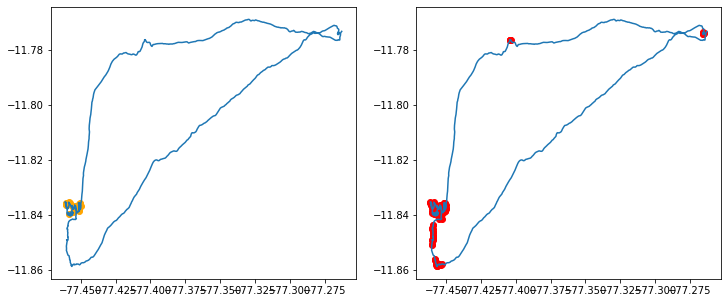

In [ ]:
t = data_test_new[data_test_new.trip == 'P1108_46_SV_T2'].copy() 

plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.prediction > 0.5], t.lat[t.prediction > 0.5], c = 'red')

# ROC curve

Change the decision threshold

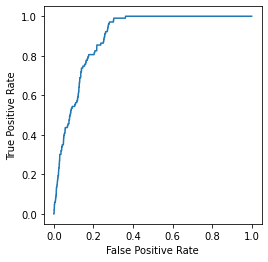

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test_new.prediction > tt)
    true_positive = np.mean(all_estim[data_test_new.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test_new.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))

# Export Probabilities

In [ ]:
data_test_new.to_csv('all_unet_prediction_5s.csv', index = False)